In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras import backend as K
from keras import initializers
from keras.engine import InputSpec, Layer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from keras import layers
from keras import regularizers
from keras.models import Model
from keras.models import Sequential
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold
from keras.layers import Dense, Dropout, Reshape, Conv1D, BatchNormalization, Activation, Flatten, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, Lambda, Input, Concatenate, Add, UpSampling1D, Multiply

In [2]:
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy

strategy = auto_select_accelerator()

Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas


In [3]:
# Reading the Preprocessed Dataset
df = pd.read_csv('../input/attention-dta/test_mtor.csv')
df = df.dropna()
df.head()

,protein_sequence,CID,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,...,protein_label_1192,protein_label_1193,protein_label_1194,protein_label_1195,protein_label_1196,protein_label_1197,protein_label_1198,protein_label_1199,protein_label_1200,protein_label_1201
0,SEESQAFQRQLTALIGYDVTDVSNVHDDELEFTRRGLVTPRMAEVA...,20744853,358.4,3.6,358.179361,358.179361,76.8,456.0,0.0,2.0,...,21,21,21,21,21,21,21,21,21,21
1,SEESQAFQRQLTALIGYDVTDVSNVHDDELEFTRRGLVTPRMAEVA...,24889392,560.7,5.6,560.220575,560.220575,134.0,849.0,0.0,2.0,...,21,21,21,21,21,21,21,21,21,21
2,SEESQAFQRQLTALIGYDVTDVSNVHDDELEFTRRGLVTPRMAEVA...,11409972,529.6,3.8,529.241308,529.241308,94.6,730.0,0.0,3.0,...,21,21,21,21,21,21,21,21,21,21
3,SEESQAFQRQLTALIGYDVTDVSNVHDDELEFTRRGLVTPRMAEVA...,11338033,382.2,2.6,381.075930,381.075930,98.9,479.0,0.0,4.0,...,21,21,21,21,21,21,21,21,21,21
4,SEESQAFQRQLTALIGYDVTDVSNVHDDELEFTRRGLVTPRMAEVA...,53445376,485.9,3.6,485.162996,485.162996,88.6,702.0,0.0,2.0,...,21,21,21,21,21,21,21,21,21,21


In [4]:
df.columns

Index(['protein_sequence', 'CID', 'MolecularWeight', 'XLogP', 'ExactMass',
       'MonoisotopicMass', 'TPSA', 'Complexity', 'Charge', 'HBondDonorCount',
       ...
       'protein_label_1192', 'protein_label_1193', 'protein_label_1194',
       'protein_label_1195', 'protein_label_1196', 'protein_label_1197',
       'protein_label_1198', 'protein_label_1199', 'protein_label_1200',
       'protein_label_1201'],
      dtype='object', length=1325)

In [5]:
df.shape

(8120, 1325)

In [6]:
obj_cols = ['id', 'index', 'ref_name', 'id', 'protein_sequence', 'label_smiles', 'label_seq']
cols = [col for col in list(df.columns) if col not in obj_cols]

In [7]:
n_gram_len = 3
ngram_overlap = 3

In [8]:
def generate_ngram_list(input_seq, n, overlap_step):
    n=1 if n<1 else n
    overlap_step=1 if overlap_step<1 else overlap_step
    # Reverse input
    input_seq = input_seq[::-1]
    output = [input_seq[ii:ii+n] for ii in np.arange(0, len(input_seq), overlap_step)]
    while(len(output[-1]) != n):
        output.pop()
    # Reverse output
    output[:] = output[::-1]
    return output

def generate_ngram_seq(input_seq, n, overlap_step):
    ngram_list = generate_ngram_list(input_seq, n, overlap_step)
    # Reverse each sequences as well
    output = (''.join([' %s' % (ngram[::-1]) for ngram in ngram_list]))
    return output

def generate_ngram_dictionary(n, source_dict):
    unique_symbols = len(source_dict)
    unique_ngrams = unique_symbols**n
    ngram_matrix=np.empty((unique_ngrams,n), dtype='U1')
    
    for ii in np.arange(n):
        change_freq = unique_symbols**(n-ii-1)
        symbol_idx = 0
        for jj in np.arange(0, unique_ngrams, change_freq):
            ngram_matrix[jj:(jj+change_freq), ii] = source_dict[symbol_idx]
            symbol_idx+=1
            if(symbol_idx == unique_symbols):
                symbol_idx=0
            
    # Reduce the second axis
    ngram_list = [ ''.join(symbol) for symbol in [l for l in ngram_matrix]]
    return ngram_list

In [9]:
%%time
aminoacid_dictionary = []
for seq in df.protein_sequence.values:
    for symbol in list(seq):
        if(not symbol in aminoacid_dictionary):
            aminoacid_dictionary.append(symbol)

CPU times: user 6.9 s, sys: 0 ns, total: 6.9 s
Wall time: 6.9 s


In [10]:
print(len(aminoacid_dictionary), aminoacid_dictionary)

20 ['S', 'E', 'Q', 'A', 'F', 'R', 'L', 'T', 'I', 'G', 'Y', 'D', 'V', 'N', 'H', 'P', 'M', 'K', 'W', 'C']


In [11]:
%%time
ngram_dict = generate_ngram_dictionary(n_gram_len, aminoacid_dictionary)
print(ngram_dict[:10])

['SSS', 'SSE', 'SSQ', 'SSA', 'SSF', 'SSR', 'SSL', 'SST', 'SSI', 'SSG']
CPU times: user 40.3 ms, sys: 0 ns, total: 40.3 ms
Wall time: 39.6 ms


In [12]:
%%time
df = df.assign(protein_ngramseq = [generate_ngram_seq(prot_seq, n_gram_len, ngram_overlap) for prot_seq in df['protein_sequence'].values])

CPU times: user 8.91 s, sys: 79.9 ms, total: 8.99 s
Wall time: 8.85 s


In [13]:
lP = np.array([int(3*len(p)/4) for p in df.protein_ngramseq.values])
np.histogram(lP, bins=[0,50,100,200,300,500,800,1000,1500,2000,3000,4000,5000])

(array([   0,    0,    0, 2030,    0,    0, 2030,    0,    0, 2030,    0,
           0]),
 array([   0,   50,  100,  200,  300,  500,  800, 1000, 1500, 2000, 3000,
        4000, 5000]))

In [14]:
maxlength = 3000

In [15]:
source = df.protein_ngramseq
num_words_dict = len(ngram_dict)

In [16]:
%%time
train_tk = Tokenizer(num_words=num_words_dict, char_level=False)
train_tk.fit_on_texts(source)

CPU times: user 4.73 s, sys: 0 ns, total: 4.73 s
Wall time: 4.72 s


In [17]:
def preprocess_data(data, tokenizer, maxlen = maxlength):
    seq = tokenizer.texts_to_sequences(data)
    padded_seq = pad_sequences(seq, maxlen=maxlen, padding='pre', truncating='pre')
    return padded_seq

In [18]:
encoded_seq = preprocess_data(source.values, train_tk, maxlength)
encoded_df = pd.DataFrame(encoded_seq)
encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0,0,0,0,0,0,0,0,0,0,...,974,304,975,976,109,977,305,978,979,306
1,0,0,0,0,0,0,0,0,0,0,...,974,304,975,976,109,977,305,978,979,306
2,0,0,0,0,0,0,0,0,0,0,...,974,304,975,976,109,977,305,978,979,306
3,0,0,0,0,0,0,0,0,0,0,...,974,304,975,976,109,977,305,978,979,306
4,0,0,0,0,0,0,0,0,0,0,...,974,304,975,976,109,977,305,978,979,306


In [19]:
encoded_df.to_csv("n_grams.csv" , index = False)

In [20]:
# Creating a map for segmenting the training dataset
drug_labels = [col for col in df.columns if str(col).startswith('drug_label_')]
protein_labels = [col for col in df.columns if str(col).startswith('protein_label_')]
drug_features = ['CID', 'MolecularWeight', 'XLogP', 'ExactMass', 'MonoisotopicMass', 'TPSA',
                 'Complexity', 'Charge', 'HBondDonorCount', 'HBondAcceptorCount', 
                 'RotatableBondCount', 'HeavyAtomCount', 'IsotopeAtomCount', 'AtomStereoCount',
                 'DefinedAtomStereoCount', 'UndefinedAtomStereoCount', 'BondStereoCount',
                 'DefinedBondStereoCount', 'UndefinedBondStereoCount', 'CovalentUnitCount',
                 'Volume3D']

len(drug_labels), len(protein_labels), len(drug_features)

(100, 1200, 21)

In [21]:
drug_label_test = df[drug_labels]
protein_label_test = df[protein_labels]
drug_feature_test = df[drug_features]
encoded_protein_test = encoded_df

In [22]:
drug_label_test = np.array(drug_label_test).reshape(-1, drug_label_test.shape[1], 1)
protein_label_test = np.array(protein_label_test).reshape(-1, protein_label_test.shape[1], 1)

In [23]:
def fc_block(input_tensor, features, activation_f='relu', wd=0.0001):
    output = Dense(features,
                   activation='relu',
                   use_bias=False)(input_tensor)
    output = layers.BatchNormalization(axis=1)(output)
    output = layers.Activation(activation_f)(output)
    
    return output

def recurrent_block(input_tensor, recurrent_layer, features, return_sequences=False, wd=0.0001):
    output = input_tensor
    output = recurrent_layer(units=features, return_sequences=return_sequences)(output)
    output = layers.BatchNormalization(axis=1)(output)
    
    return output

def sequence_feat_extractor(input_tensor, recurrent_layer, return_sequences=False, wd=0.0001):
    output = input_tensor
    output = recurrent_block(output, recurrent_layer, 128, return_sequences=return_sequences)
    return output

def branch_extractor(input_tensor, dropout_rate=0.5):
    output = input_tensor
    output = sequence_feat_extractor(output, layers.LSTM, return_sequences=True)
    output = sequence_feat_extractor(output, layers.LSTM, return_sequences=False)
    output = fc_block(output, 64, activation_f='elu')
    output = layers.Dropout(dropout_rate)(output)
    return output

In [24]:
class AttLayer(Layer):
    def __init__(self, use_bias=True, activation ='tanh', **kwargs):
        self.init = initializers.get('normal')
        self.use_bias = use_bias
        self.activation = activation
        super(AttLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape)==3
        self.W = self.add_weight(name='kernel', 
                                 shape=(input_shape[-1],1),
                                 initializer='normal',
                                 trainable=True)
        if self.use_bias:
            self.bias = self.add_weight(name='bias', 
                                      shape=(1,),
                                      initializer='zeros',
                                      trainable=True)
        else:
            self.bias = None
        super(AttLayer, self).build(input_shape) 

    def call(self, x, mask=None):
        eij = K.dot(x, self.W)
        if self.use_bias:
            eij = K.bias_add(eij, self.bias)
        if self.activation == 'tanh':
            eij = K.tanh(eij)
        elif self.activation =='relu':
            eij = K.relu(eij)
        else:
            eij = eij
        ai = K.exp(eij)
        weights = ai/K.sum(ai, axis=1, keepdims=True)
        weighted_input = x*weights
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = { 'activation': self.activation }
        base_config = super(AttLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [25]:
def ann_convnet_composite(dropout_val):
    with strategy.scope():
        # define input layers
        protein_seq_input = layers.Input(batch_shape=(None, maxlength))
        protein_label_input = layers.Input((protein_label_test.shape[1], 1))
        drug_label_input = layers.Input(shape=(drug_label_test.shape[1], 1))
        drug_feat_input = layers.Input(shape=drug_feature_test.shape[1])

        # define main input processing layers
        input_batch_norm = layers.BatchNormalization()(drug_feat_input)
        hidden_1 = layers.Dense(512, activation='relu')(input_batch_norm)
        hidden_2 = layers.Dense(256, activation='relu')(hidden_1)
        batch_norm_1 = layers.BatchNormalization()(hidden_2)
        dropout_1 = layers.Dropout(dropout_val)(batch_norm_1)

        # define convolutional layers for protein labels
        protein_label_conv1 = layers.Conv1D(256, 4, activation='relu')(protein_label_input)
        protein_label_conv2 = layers.Conv1D(128, 8, activation='relu')(protein_label_conv1)
        protein_label_conv3 = layers.Conv1D(64, 12, activation='relu')(protein_label_conv2)
        protein_label_att = AttLayer()(protein_label_conv3)
        protein_label_flatten = layers.Flatten()(protein_label_att)

        # define convolutional layers for drug labels
        drug_label_conv1 = layers.Conv1D(32, 4, activation='relu')(drug_label_input)
        drug_label_conv2 = layers.Conv1D(16, 8, activation='relu')(drug_label_conv1)
        drug_label_conv3 = layers.Conv1D(16, 8, activation='relu')(drug_label_conv2)
        drug_label_att = AttLayer()(drug_label_conv3)
        drug_label_flatten = layers.Flatten()(drug_label_att)

        # define convolutional layers for protein sequence
        protein_seq_embedding = layers.Embedding(input_dim = num_words_dict, input_length=maxlength, output_dim = 512, embeddings_regularizer=regularizers.l2(wd))(protein_seq_input)
        protein_seq_branch_ext = branch_extractor(protein_seq_embedding)
        protein_seq_flatten = layers.Flatten()(protein_seq_branch_ext)

        # combine our multiple inputs into one
        concat_layer = layers.concatenate([dropout_1, protein_label_flatten, drug_label_flatten, protein_seq_flatten])

        # follow-up dense layers
        hidden_2 = layers.Dense(256, activation='relu')(concat_layer)
        batch_norm_2 = layers.BatchNormalization()(hidden_2)
        dropout_2 = layers.Dropout(dropout_val)(batch_norm_2)

        hidden_3 = layers.Dense(256, activation='relu')(dropout_2)
        batch_norm_3 = layers.BatchNormalization()(hidden_3)
        dropout_3 = layers.Dropout(dropout_val)(batch_norm_3)

        # main output for our scored labels
        output_1 = layers.Dense(1, activation='linear')(dropout_3)
        model = keras.Model(inputs=[protein_seq_input, protein_label_input, drug_label_input, drug_feat_input], outputs=[output_1])
        model.compile(optimizer='adam', loss = 'mse', metrics =['mae', 'mse'])
    return model

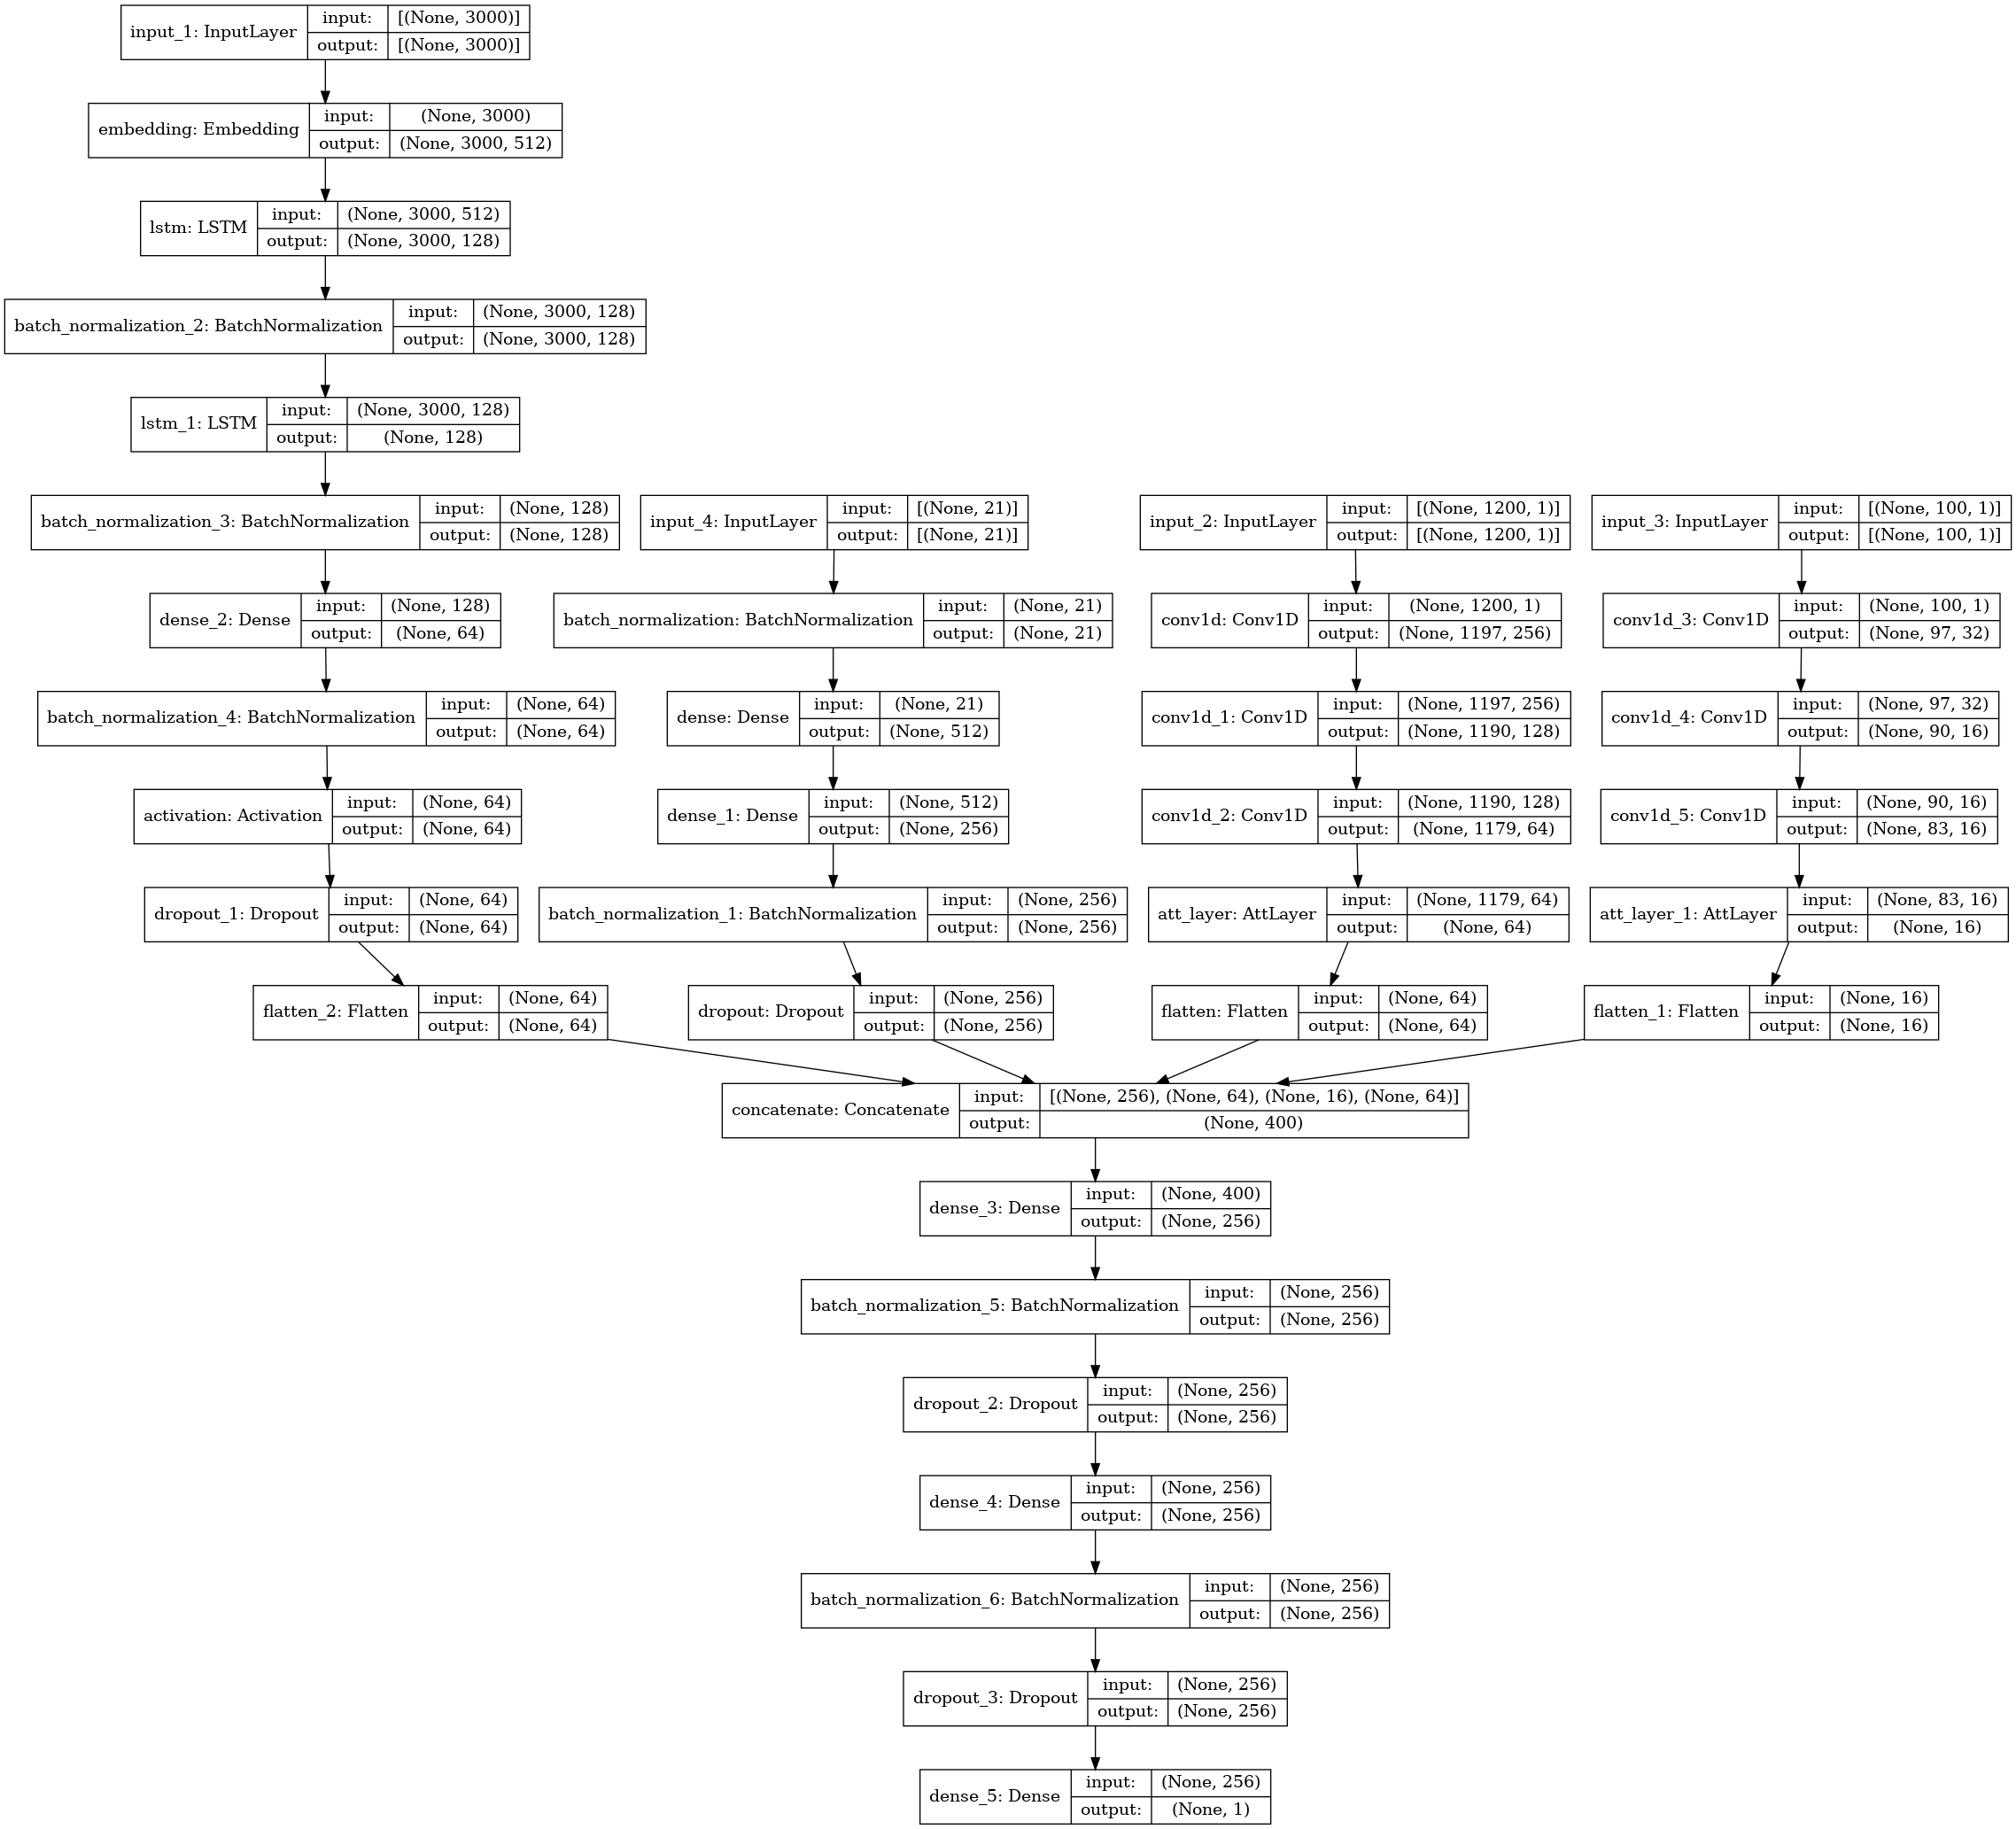

In [26]:
weight_decay = wd = 0.0001
model = ann_convnet_composite(dropout_val=0.2)
keras.utils.plot_model(model, "composite_model.png", show_shapes=True)

In [27]:
model.load_weights("../input/attention-dta-test/NN_best_loss.h5")

In [28]:
test_dataset = [encoded_protein_test, protein_label_test, drug_label_test, drug_feature_test]
y_preds = model.predict(test_dataset)

In [29]:
df['predictions'] = y_preds/10

In [30]:
results = df[['id', 'protein_sequence', 'predictions']].sort_values(by=['predictions'], ascending=False)
results = results.head(100)

In [31]:
!pip install pubchempy

  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13825 sha256=4d6fb7f03160c474b5ee41604da4cf97e245366762ebbd140aeeaae9bd7015ce
  Stored in directory: /root/.cache/pip/wheels/7c/3d/8c/8192697412e9899dc55bbbb08bbc1197bef333caaa2a71c448
Successfully built pubchempy


In [32]:
import pubchempy as pcp

In [33]:
names = []
for i in results['id']:
    props = pcp.get_properties(['IUPACName', ], i, 'smiles')
    names.append(props[0]['IUPACName'])

In [34]:
results['IUPACName'] = names

In [35]:
results.to_csv("results.csv" , index = False)